In [1]:
%matplotlib inline

import xarray as xa
import netCDF4 as nc
import pandas as pd
import numpy as np
import urllib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
### Plot settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['svg.fonttype'] = 'none'

The following cell loads the dataset from an ERDDAP server.  It can be accessed like a opendap/thredds server for netcdf, but sends the data in a **streaming** format which is hard to figure out how to parse.  So instead, download a temporary file specifying the parameters in the url. 

Alternatives would be to access streaming version of csv file or other filetype from ERDDAP Server and process via pandas

In [3]:
OcculusGlider = "http://krafla.pmel.noaa.gov:8080/erddap/tabledap/sg401_b9ae_ed68_1861"
cmap = cmocean.cm.thermal
temp_filename = "data/ogtmp.nc"

start_date="2017-07-15"
end_date  ="2017-12-31" 
urllib.urlretrieve(OcculusGlider+".ncCFMA?profileid%2Ctemperature%2Csalinity%2Cdepth%2Ctime&time%3E="+start_date+"T23%3A52%3A00Z&glider=%22Seaglider%20SG401%22",temp_filename)

start_date_dt = datetime.datetime.strptime(start_date,"%Y-%m-%d"),
end_date_dt   = datetime.datetime.strptime(end_date,"%Y-%m-%d")

### Analysis portion.

**Purpose: What is the daily distance travelled in nm of the glider?**

**Method: Calculate the distance between dives on a great circle.  Then sum up each day.  This will give the total distance travelled as opposed to the geometric distance between the first and last dive**

In [4]:
#datanc = nc.Dataset('data/tmp.nc') #using netcdf library
dataxa = xa.open_dataset('data/ogtmp.nc')

#print dataxa

In [58]:
lat = dataxa.latitude.groupby('profile').mean().values
lon = dataxa.longitude.groupby('profile').mean().values
datatime = dataxa.time.groupby('profile').first().values

In [64]:
from geographiclib.geodesic import Geodesic
import numpy as np


In [95]:
distance = np.ones_like(lat) -1
proftime = np.array([])

for i,v in enumerate(lat):
    proftime = np.hstack([proftime,pd.Timestamp(datatime[i][0]).to_pydatetime()])
    distance[i] = Geodesic.WGS84.Inverse(lat[i],lon[i],lat[i+1],lon[i+1])['s12'] #meters


IndexError: index 3562 is out of bounds for axis 0 with size 3562

In [108]:
df = pd.DataFrame(data=distance,index=proftime,columns=['distance'])

In [131]:
dailydistance = df.groupby(pd.TimeGrouper(freq='D')).sum()

#meter to Nautical Mile = x*0.000539957


/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


In [140]:
dailydistance['nm'] = dailydistance['distance']*0.000539957

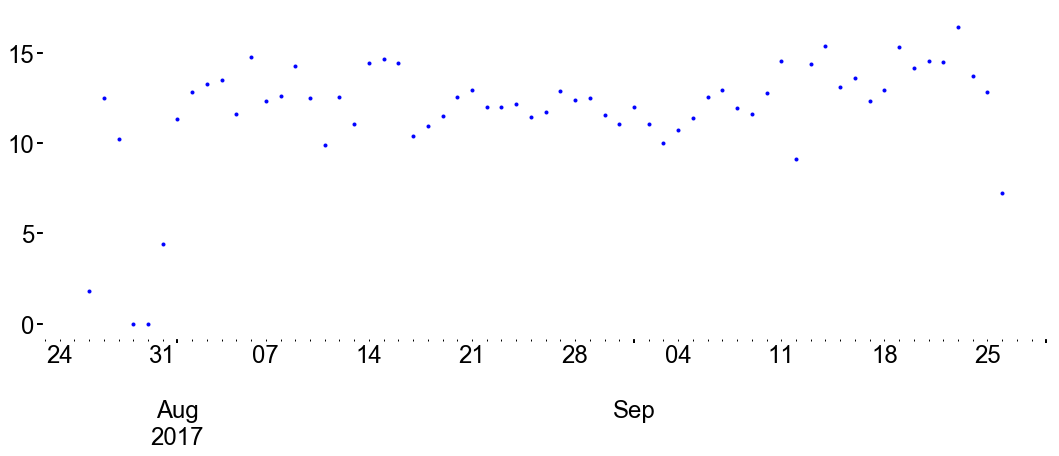

In [153]:
plt.figure(1, figsize=(18, 6), facecolor='w', edgecolor='w')
plt.subplot(1,1,1)
dailydistance.nm.plot(style='b.')